In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer
import xgboost as xgb
import numpy as np


In [2]:
# Carregar o dataset
df = pd.read_csv('./datasets/casas_ponta_grossa.csv', delimiter=',')

# Verificando a presença de NaNs
print("Quantidade de valores ausentes:")
print(df.isna().sum())

# Retirando valores NaN:
df = df[df['Quartos'].notna()]
df = df[df['Banheiros'].notna()]
df = df[df['Suítes'].notna()]
df = df[df['Vagas de Garagem'].notna()]
df = df[df['Bairro'].notna()]
df = df[df['Área Total'].notna()]
dfFiltrado = df[df['Valor Venda'].notna()]

# Filtrando as casas com valor de venda entre 200k e 1 milhão
dfFiltrado = dfFiltrado[(dfFiltrado['Valor Venda'] >= 50000) & (dfFiltrado['Valor Venda'] <= 5000000)]

# Verificando as estatísticas descritivas para detectar valores extremos
print("\nEstatísticas Descritivas:")
print(dfFiltrado.describe())


Quantidade de valores ausentes:
Referência             0
Quartos              362
Banheiros            582
Suítes                 0
Vagas de Garagem    1247
Bairro                 0
Área Total           815
Valor Venda            3
dtype: int64

Estatísticas Descritivas:
           Quartos    Banheiros       Suítes  Vagas de Garagem   Área Total  \
count  1686.000000  1686.000000  1686.000000       1686.000000  1686.000000   
mean      3.013642     2.424081     0.925860          2.212337   238.700474   
std       0.791905     1.354580     1.017862          1.219521   214.755006   
min       1.000000     1.000000     0.000000          1.000000    24.000000   
25%       3.000000     1.000000     0.000000          1.000000    99.250000   
50%       3.000000     2.000000     1.000000          2.000000   179.000000   
75%       3.000000     3.000000     1.000000          3.000000   315.750000   
max       8.000000     8.000000     5.000000         10.000000  2500.000000   

        Valor Ve

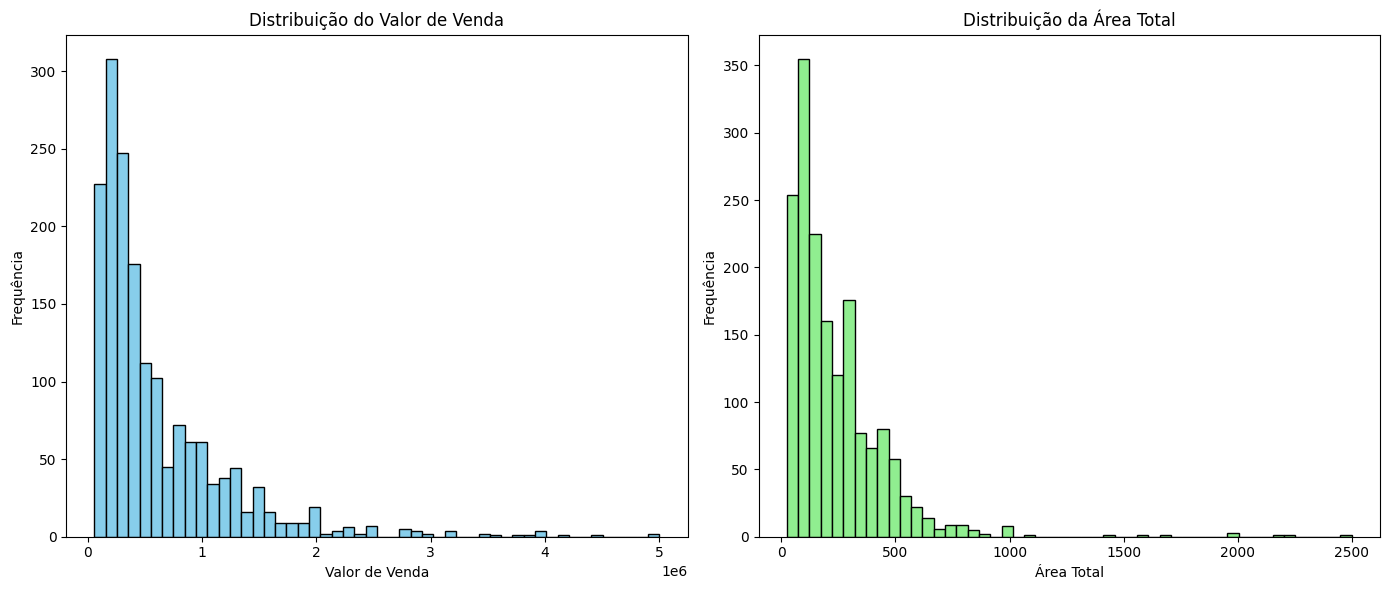

In [3]:
# Plotando gráficos para verificar as distribuições dos dados
# Histograma de 'Valor Venda' e 'Área Total'
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(dfFiltrado['Valor Venda'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribuição do Valor de Venda')
plt.xlabel('Valor de Venda')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
plt.hist(dfFiltrado['Área Total'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribuição da Área Total')
plt.xlabel('Área Total')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

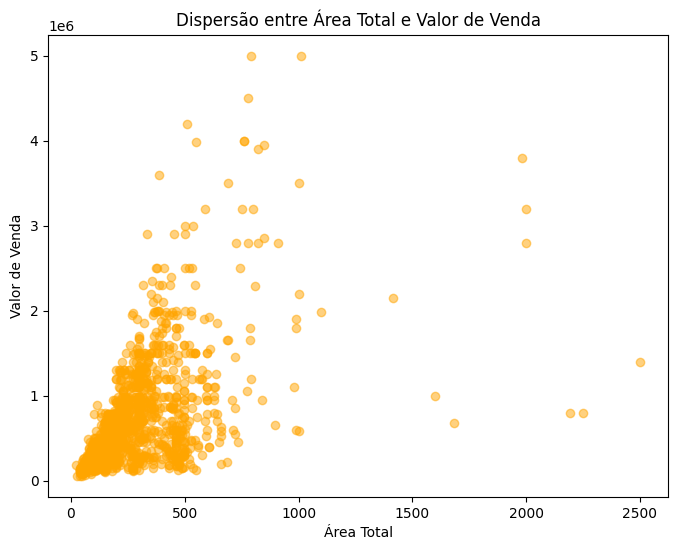

In [4]:
# Gráfico de dispersão entre 'Área Total' e 'Valor Venda'
plt.figure(figsize=(8, 6))
plt.scatter(dfFiltrado['Área Total'], dfFiltrado['Valor Venda'], alpha=0.5, color='orange')
plt.title('Dispersão entre Área Total e Valor de Venda')
plt.xlabel('Área Total')
plt.ylabel('Valor de Venda')
plt.show()

In [5]:
# Verificando a correlação entre variáveis numéricas
correlation_matrix = dfFiltrado[['Área Total', 'Quartos', 'Banheiros', 'Suítes', 'Vagas de Garagem', 'Valor Venda']].corr()
print("\nMatriz de Correlação:")
print(correlation_matrix)


Matriz de Correlação:
                  Área Total   Quartos  Banheiros    Suítes  Vagas de Garagem  \
Área Total          1.000000  0.430017   0.424466  0.410641          0.406750   
Quartos             0.430017  1.000000   0.548962  0.473942          0.439455   
Banheiros           0.424466  0.548962   1.000000  0.757568          0.463507   
Suítes              0.410641  0.473942   0.757568  1.000000          0.415731   
Vagas de Garagem    0.406750  0.439455   0.463507  0.415731          1.000000   
Valor Venda         0.604109  0.497991   0.679090  0.702975          0.499390   

                  Valor Venda  
Área Total           0.604109  
Quartos              0.497991  
Banheiros            0.679090  
Suítes               0.702975  
Vagas de Garagem     0.499390  
Valor Venda          1.000000  


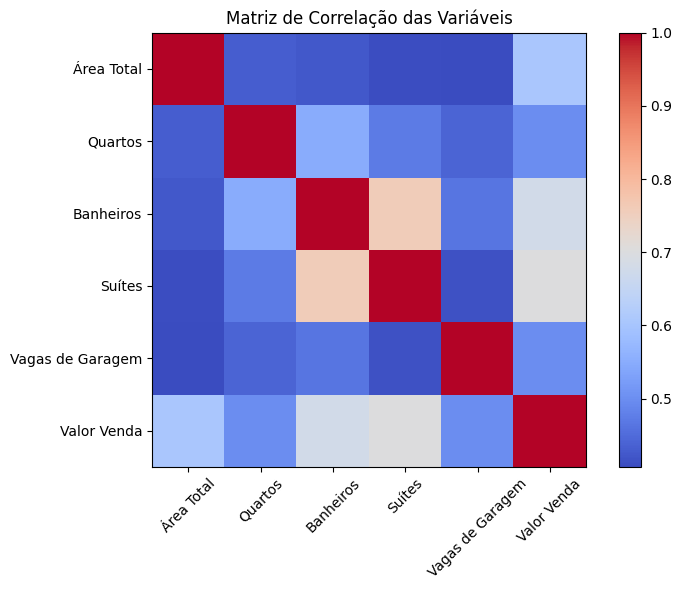

In [6]:
# Heatmap de correlação
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(np.arange(correlation_matrix.shape[1]), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(correlation_matrix.shape[0]), correlation_matrix.index)
plt.title('Matriz de Correlação das Variáveis')
plt.tight_layout()
plt.show()

In [7]:
# Engenharia de Features
# Transformando a coluna 'Bairro' com LabelEncoder
le = LabelEncoder()
dfFiltrado['Bairro'] = le.fit_transform(dfFiltrado['Bairro'])

# Normalizando as variáveis numéricas
scaler = QuantileTransformer(output_distribution='normal')  # Usando QuantileTransformer para robustez
dfFiltrado[['Área Total', 'Quartos', 'Banheiros', 'Suítes', 'Vagas de Garagem']] = scaler.fit_transform(
    dfFiltrado[['Área Total', 'Quartos', 'Banheiros', 'Suítes', 'Vagas de Garagem']]
)

# Criando novas colunas
dfFiltrado['Preco por m2'] = dfFiltrado['Valor Venda'] / dfFiltrado['Área Total']
dfFiltrado['Faixa de Preço'] = pd.cut(dfFiltrado['Valor Venda'], bins=[1000000, 2000000, 3500000, 5000000], labels=['Baixo', 'Médio', 'Alto'])
dfFiltrado['Quartos por m2'] = dfFiltrado['Quartos'] / dfFiltrado['Área Total']
dfFiltrado['Banheiros por m2'] = dfFiltrado['Banheiros'] / dfFiltrado['Área Total']
dfFiltrado['Vagas de Garagem por m2'] = dfFiltrado['Vagas de Garagem'] / dfFiltrado['Área Total']

# Novas colunas sugeridas
dfFiltrado['Área Total * Quartos'] = dfFiltrado['Área Total'] * dfFiltrado['Quartos']
dfFiltrado['Área Total * Banheiros'] = dfFiltrado['Área Total'] * dfFiltrado['Banheiros']
dfFiltrado['Diferença Preço - Média Bairro'] = dfFiltrado['Valor Venda'] - dfFiltrado.groupby('Bairro')['Valor Venda'].transform('mean')
dfFiltrado['Bairro por Faixa de Preço'] = dfFiltrado['Bairro'] * dfFiltrado['Faixa de Preço'].cat.codes
dfFiltrado['Área por Quartos'] = dfFiltrado['Área Total'] / dfFiltrado['Quartos']
dfFiltrado['Área por Banheiros'] = dfFiltrado['Área Total'] / dfFiltrado['Banheiros']

# Convertendo a coluna 'Faixa de Preço' para valores numéricos (inteiros)
dfFiltrado['Faixa de Preço'] = dfFiltrado['Faixa de Preço'].cat.codes

# Definindo as features (X) e o alvo (y)
X = dfFiltrado[['Quartos', 'Banheiros', 'Suítes', 'Vagas de Garagem', 'Bairro', 'Área Total', 'Preco por m2', 'Faixa de Preço', 
                'Quartos por m2', 'Banheiros por m2', 'Vagas de Garagem por m2', 'Área Total * Quartos', 
                'Área Total * Banheiros', 'Diferença Preço - Média Bairro', 'Bairro por Faixa de Preço', 
                'Área por Quartos', 'Área por Banheiros']]
y = dfFiltrado['Valor Venda']

In [8]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tuning de Hiperparâmetros com RandomizedSearchCV para o modelo XGBoost
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, cv=5, verbose=1, scoring='neg_mean_absolute_error', random_state=42)
xgb_random_search.fit(X_train, y_train)

# Melhor modelo XGBoost
best_xgb_model = xgb_random_search.best_estimator_

# Previsões e avaliação para XGBoost
y_pred_xgb = best_xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost - RMSE: {rmse_xgb}")
print(f"XGBoost - MAE: {mae_xgb}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBoost - RMSE: 77419.83838332203
XGBoost - MAE: 45303.575050850595


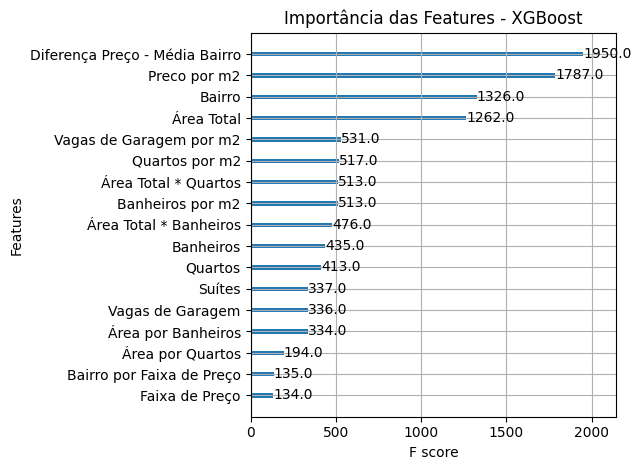

In [9]:
# Visualizando a importância das features com XGBoost
xgb.plot_importance(best_xgb_model)
plt.title('Importância das Features - XGBoost')
plt.tight_layout()
plt.show()


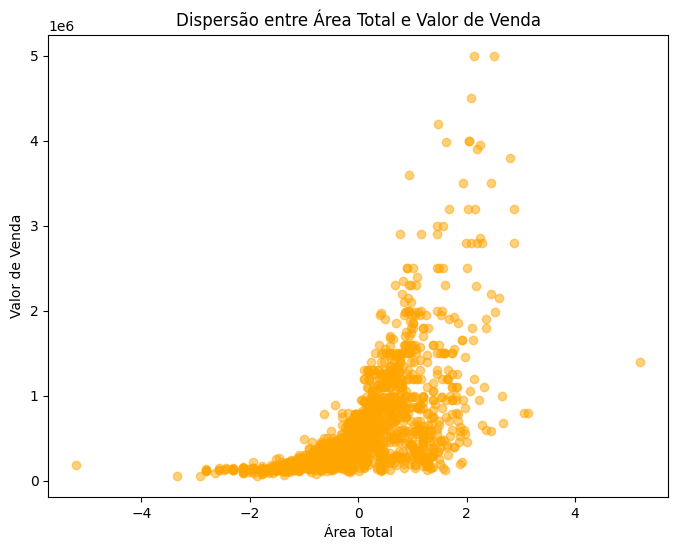

In [10]:
# Gráfico de dispersão entre 'Área Total' e 'Valor Venda' (novamente)
plt.figure(figsize=(8, 6))
plt.scatter(dfFiltrado['Área Total'], dfFiltrado['Valor Venda'], alpha=0.5, color='orange')
plt.title('Dispersão entre Área Total e Valor de Venda')
plt.xlabel('Área Total')
plt.ylabel('Valor de Venda')
plt.show()


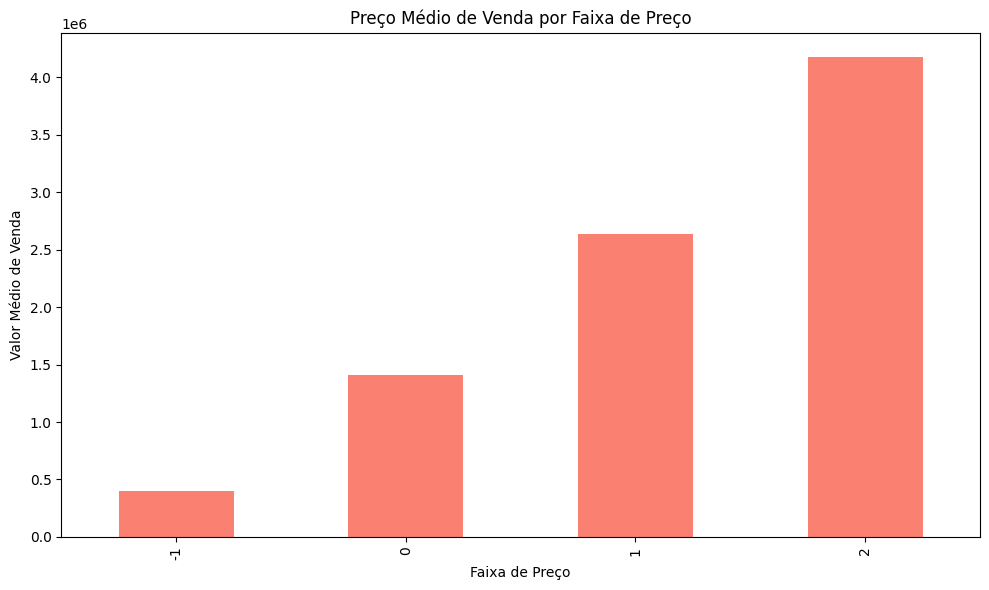

In [11]:
# Gráfico de 'Faixa de Preço' vs 'Valor de Venda'
plt.figure(figsize=(10, 6))
dfFiltrado.groupby('Faixa de Preço')['Valor Venda'].mean().plot(kind='bar', color='salmon')
plt.title('Preço Médio de Venda por Faixa de Preço')
plt.xlabel('Faixa de Preço')
plt.ylabel('Valor Médio de Venda')
plt.tight_layout()
plt.show()
